<a href="https://colab.research.google.com/github/anagh07/stock_price_predictor/blob/master/lagged_feature_engineering_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
!pip install pyspark
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import Window

import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV



In [45]:
%pwd

'/content'

In [46]:
def init_spark():
    spark = SparkSession \
        .builder \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()
    return spark

# read and clean the csv
spark = init_spark()
filename = '/content/drive/MyDrive/data/stock_histories.csv'
df = spark.read.csv(filename, header=True, mode="DROPMALFORMED")

In [77]:
df = df.withColumn("volume",df.volume.cast(IntegerType()))
df = df.withColumn("open",df.open.cast(FloatType()))
df = df.withColumn("close",df.close.cast(FloatType()))
df = df.withColumn("adjusted_close",df.close.cast(FloatType()))
df = df.withColumn("high",df.high.cast(FloatType()))
df = df.withColumn("low",df.low.cast(FloatType()))

In [78]:
nvda = df.where(df.stock == "NVDA")

In [8]:
nvda.show()

+-----+----------+--------+------+------+------+------+--------------+
|stock|      date|  volume|  open| close|  high|   low|adjusted_close|
+-----+----------+--------+------+------+------+------+--------------+
| NVDA|2018-11-02|11320900|217.73|214.92| 222.0|210.21|        214.92|
| NVDA|2018-11-01|14163200| 212.3|218.11|218.49|207.19|        218.11|
| NVDA|2018-10-31|18644300|209.65|210.83|212.59|204.01|        210.83|
| NVDA|2018-10-30|20179800|186.55| 203.0| 203.4|185.62|         203.0|
| NVDA|2018-10-29|18950400|203.99|185.62|204.13|176.01|        185.62|
| NVDA|2018-10-26|16619600|198.31|198.29|204.84|193.12|        198.29|
| NVDA|2018-10-25|23793000|195.47|207.84|209.75|193.68|        207.84|
| NVDA|2018-10-24|22107200|219.51|199.41|221.39|198.85|        199.41|
| NVDA|2018-10-23|15660900|220.43|221.06|224.19|216.71|        221.06|
| NVDA|2018-10-22| 9221100|231.28|231.22|235.32|227.07|        231.22|
| NVDA|2018-10-19|15340200|241.76|229.17|242.55| 227.7|        229.17|
| NVDA

In [9]:
nvda.orderBy(["date"]).select("date").first()

Row(date='1999-01-22')

In [10]:
nvda.orderBy(["date"], ascending=False).select("date").first()

Row(date='2018-11-02')

In [11]:
# feature engineering: Quarter, week of year, year, day of week
nvda = nvda.withColumn("quarter", quarter(col("date")))
nvda = nvda.withColumn("week_of_year", weekofyear(col("date")))
nvda = nvda.withColumn("year", year(col("date")))
nvda = nvda.withColumn("day_of_week", dayofweek(col("date")))
nvda = nvda.withColumn("year_quarter", concat(nvda.year, lit("-"), nvda.quarter).alias("year_quarter"))

In [12]:
nvda.select("date", "quarter", "week_of_year", "year", "day_of_week", "year_quarter").show()

+----------+-------+------------+----+-----------+------------+
|      date|quarter|week_of_year|year|day_of_week|year_quarter|
+----------+-------+------------+----+-----------+------------+
|2018-11-02|      4|          44|2018|          6|      2018-4|
|2018-11-01|      4|          44|2018|          5|      2018-4|
|2018-10-31|      4|          44|2018|          4|      2018-4|
|2018-10-30|      4|          44|2018|          3|      2018-4|
|2018-10-29|      4|          44|2018|          2|      2018-4|
|2018-10-26|      4|          43|2018|          6|      2018-4|
|2018-10-25|      4|          43|2018|          5|      2018-4|
|2018-10-24|      4|          43|2018|          4|      2018-4|
|2018-10-23|      4|          43|2018|          3|      2018-4|
|2018-10-22|      4|          43|2018|          2|      2018-4|
|2018-10-19|      4|          42|2018|          6|      2018-4|
|2018-10-18|      4|          42|2018|          5|      2018-4|
|2018-10-17|      4|          42|2018|  

In [13]:
# get last full quarter
# step 1: calculate days in each quarters - a full quarter has at least 60 days 
quarter_day_count = nvda.groupby("year_quarter").count()\
                                                .filter("count >= 60")
last_quarter = quarter_day_count.orderBy(["year_quarter"], ascending=False).select("year_quarter").first()

In [14]:
last_quarter[0]

'2018-3'

In [15]:
quarter_day_count = quarter_day_count.withColumn("is_test", when(col("year_quarter") == last_quarter[0], 1).otherwise(0))

In [16]:
quarter_day_count.show()

+------------+-----+-------+
|year_quarter|count|is_test|
+------------+-----+-------+
|      2003-4|   64|      0|
|      2006-2|   63|      0|
|      2014-1|   61|      0|
|      2013-4|   64|      0|
|      2000-1|   63|      0|
|      2012-1|   62|      0|
|      2010-1|   61|      0|
|      2005-2|   64|      0|
|      2000-4|   63|      0|
|      2005-1|   61|      0|
|      2010-3|   64|      0|
|      2010-2|   63|      0|
|      2011-3|   64|      0|
|      2007-2|   63|      0|
|      2013-2|   64|      0|
|      2009-1|   61|      0|
|      2001-1|   62|      0|
|      2002-3|   64|      0|
|      2002-2|   64|      0|
|      2014-4|   64|      0|
+------------+-----+-------+
only showing top 20 rows



In [17]:
nvda = nvda.join(quarter_day_count, "year_quarter")

In [18]:
nvda.count()

4848

In [19]:
open_average = nvda.groupby("year_quarter")\
                   .agg(avg("open").alias("open_avg"))
windowSpec = Window.orderBy("year_quarter")
open_average = open_average.withColumn("open_avg_l1", lag("open_avg", 1).over(windowSpec))
open_average = open_average.withColumn("open_avg_l2", lag("open_avg", 2).over(windowSpec))
open_average = open_average.withColumn("open_avg_l3", lag("open_avg", 3).over(windowSpec))
open_average = open_average.withColumn("open_avg_l4", lag("open_avg", 4).over(windowSpec))
open_average = open_average.drop("open_avg") # drop unused col

In [20]:
volume_average = nvda.groupby("year_quarter")\
                     .agg(avg("volume").alias("volume_avg"))
volume_average = volume_average.withColumn("volume_avg_l1", lag("volume_avg", 1).over(windowSpec))
volume_average = volume_average.withColumn("volume_avg_l2", lag("volume_avg", 2).over(windowSpec))
volume_average = volume_average.withColumn("volume_avg_l3", lag("volume_avg", 3).over(windowSpec))
volume_average = volume_average.withColumn("volume_avg_l4", lag("volume_avg", 4).over(windowSpec))
volume_average = volume_average.drop("volume_avg") # drop unused col

In [21]:
high_average = nvda.groupby("year_quarter")\
                   .agg(avg("high").alias("high_avg"))
high_average = high_average.withColumn("high_avg_l1", lag("high_avg", 1).over(windowSpec))
high_average = high_average.withColumn("high_avg_l2", lag("high_avg", 2).over(windowSpec))
high_average = high_average.withColumn("high_avg_l3", lag("high_avg", 3).over(windowSpec))
high_average = high_average.withColumn("high_avg_l4", lag("high_avg", 4).over(windowSpec))
high_average = high_average.drop("high_avg") # drop unused col

In [22]:
low_average = nvda.groupby("year_quarter")\
                   .agg(avg("low").alias("low_avg"))
low_average = low_average.withColumn("low_avg_l1", lag("low_avg", 1).over(windowSpec))
low_average = low_average.withColumn("low_avg_l2", lag("low_avg", 2).over(windowSpec))
low_average = low_average.withColumn("low_avg_l3", lag("low_avg", 3).over(windowSpec))
low_average = low_average.withColumn("low_avg_l4", lag("low_avg", 4).over(windowSpec))
low_average = low_average.drop("low_avg") # drop unused col

In [23]:
close_average = nvda.groupby("year_quarter")\
                    .agg(avg("close").alias("close_avg"))
close_average = close_average.withColumn("close_avg_l1", lag("close_avg", 1).over(windowSpec))
close_average = close_average.withColumn("close_avg_l2", lag("close_avg", 2).over(windowSpec))
close_average = close_average.withColumn("close_avg_l3", lag("close_avg", 3).over(windowSpec))
close_average = close_average.withColumn("close_avg_l4", lag("close_avg", 4).over(windowSpec))
close_average = close_average.drop("close_avg") # drop unused col

In [24]:
adj_close_average = nvda.groupby("year_quarter")\
                        .agg(avg("adjusted_close").alias("adj_close_avg"))
adj_close_average = adj_close_average.withColumn("adj_close_avg_l1", lag("adj_close_avg", 1).over(windowSpec))
adj_close_average = adj_close_average.withColumn("adj_close_avg_l2", lag("adj_close_avg", 2).over(windowSpec))
adj_close_average = adj_close_average.withColumn("adj_close_avg_l3", lag("adj_close_avg", 3).over(windowSpec))
adj_close_average = adj_close_average.withColumn("adj_close_avg_l4", lag("adj_close_avg", 4).over(windowSpec))
adj_close_average = adj_close_average.drop("adj_close_avg") # drop unused col

In [25]:
nvda = nvda.join(open_average, "year_quarter")\
           .join(volume_average, "year_quarter")\
           .join(high_average, "year_quarter")\
           .join(low_average, "year_quarter")\
           .join(close_average, "year_quarter")\
           .join(adj_close_average, "year_quarter")

In [26]:
open_average.show(5)

+------------+------------------+------------------+------------------+------------------+
|year_quarter|       open_avg_l1|       open_avg_l2|       open_avg_l3|       open_avg_l4|
+------------+------------------+------------------+------------------+------------------+
|      1999-2|              null|              null|              null|              null|
|      1999-3|1.5172783136367798|              null|              null|              null|
|      1999-4|1.8688963577151299|1.5172783136367798|              null|              null|
|      2000-1| 2.627888672053814|1.8688963577151299|1.5172783136367798|              null|
|      2000-2| 5.248697753936526| 2.627888672053814|1.8688963577151299|1.5172783136367798|
+------------+------------------+------------------+------------------+------------------+
only showing top 5 rows



In [27]:
sc = spark.sparkContext
sc.setLogLevel("ERROR")

In [28]:
# drop rows with nulls (i.e. first four quarters)
nvda = nvda.na.drop()

In [29]:
nvda = nvda.toPandas()
nvda.columns

Index(['year_quarter', 'stock', 'date', 'volume', 'open', 'close', 'high',
       'low', 'adjusted_close', 'quarter', 'week_of_year', 'year',
       'day_of_week', 'count', 'is_test', 'open_avg_l1', 'open_avg_l2',
       'open_avg_l3', 'open_avg_l4', 'volume_avg_l1', 'volume_avg_l2',
       'volume_avg_l3', 'volume_avg_l4', 'high_avg_l1', 'high_avg_l2',
       'high_avg_l3', 'high_avg_l4', 'low_avg_l1', 'low_avg_l2', 'low_avg_l3',
       'low_avg_l4', 'close_avg_l1', 'close_avg_l2', 'close_avg_l3',
       'close_avg_l4', 'adj_close_avg_l1', 'adj_close_avg_l2',
       'adj_close_avg_l3', 'adj_close_avg_l4'],
      dtype='object')

In [30]:
predictor_features = ['quarter', 'week_of_year', 'year', 'day_of_week', 'open_avg_l1', 'open_avg_l2',
                      'open_avg_l3', 'open_avg_l4', 'volume_avg_l1', 'volume_avg_l2', 'volume_avg_l3', 
                      'volume_avg_l4', 'high_avg_l1', 'high_avg_l2', 'high_avg_l3', 'high_avg_l4', 
                      'low_avg_l1', 'low_avg_l2', 'low_avg_l3', 'low_avg_l4', 'close_avg_l1', 'close_avg_l2', 
                      'close_avg_l3', 'close_avg_l4', 'adj_close_avg_l1', 'adj_close_avg_l2', 'adj_close_avg_l3', 
                      'adj_close_avg_l4']

In [31]:
len(predictor_features)

28

In [32]:
from sklearn.preprocessing import MinMaxScaler

# scale the arrays to keep the values between 0 and 1 to match outcomes found in sigmoid or step functions that are used for activation.
minMaxScale = MinMaxScaler()
all_features = predictor_features.copy()
all_features.append('adjusted_close')

minMaxScale.fit(nvda[nvda.is_test == 0][all_features])
testingset = minMaxScale.transform(nvda[nvda.is_test == 1][all_features])
trainingset = minMaxScale.transform(nvda[nvda.is_test == 0][all_features])

In [49]:
x_train, x_test = trainingset[:, 0:-1], testingset[:, 0:-1]
y_train, y_test = trainingset[:, -1:], testingset[:, -1:]

In [35]:
import numpy as np
from keras import models, layers

# Build a Sequential model
model = models.Sequential()
model.add(layers.LSTM(1, input_shape=(1,len(predictor_features)), return_sequences=True))
model.add(layers.LSTM(1, input_shape=(1,len(predictor_features))))
model.add(layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [36]:
# Transform the testing and training data sets into three-dimensional arrays,  batch size, a number of time steps, and a number of features
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

print('The shape of xtrain is {}: '.format(x_train.shape))
print('The shape of xtest is {}: '.format(x_test.shape))


The shape of xtrain is (4531, 1, 28): 
The shape of xtest is (63, 1, 28): 


In [37]:
# train the model
loss = model.fit(x_train, y_train, batch_size=10, epochs=100)

Epoch 1/100
454/454 [==============================] - 7s 5ms/step - loss: 0.0248
Epoch 2/100
454/454 [==============================] - 3s 6ms/step - loss: 0.0064
Epoch 3/100
454/454 [==============================] - 3s 6ms/step - loss: 0.0027
Epoch 4/100
454/454 [==============================] - 3s 6ms/step - loss: 0.0018
Epoch 5/100
454/454 [==============================] - 3s 6ms/step - loss: 0.0014
Epoch 6/100
454/454 [==============================] - 3s 6ms/step - loss: 0.0012
Epoch 7/100
454/454 [==============================] - 3s 6ms/step - loss: 0.0012
Epoch 8/100
454/454 [==============================] - 3s 6ms/step - loss: 0.0010
Epoch 9/100
454/454 [==============================] - 2s 5ms/step - loss: 9.5117e-04
Epoch 10/100
454/454 [==============================] - 3s 6ms/step - loss: 8.2919e-04
Epoch 11/100
454/454 [==============================] - 3s 6ms/step - loss: 7.4801e-04
Epoch 12/100
454/454 [==============================] - 2s 5ms/step - loss: 6.9611e-

In [47]:
# testing the model
predict = model.predict(x_test)
predict

array([[1.0086792 ],
       [1.0079856 ],
       [1.0072887 ],
       [1.0065894 ],
       [1.0058868 ],
       [1.0049922 ],
       [1.0042851 ],
       [1.0035751 ],
       [1.002862  ],
       [1.002146  ],
       [1.0012414 ],
       [1.0005208 ],
       [0.99979705],
       [0.9990701 ],
       [0.9983404 ],
       [0.99742573],
       [0.9966911 ],
       [0.9959534 ],
       [0.99521273],
       [0.99354416],
       [0.9927953 ],
       [0.99204344],
       [0.9912881 ],
       [0.9905301 ],
       [0.98959494],
       [0.9888318 ],
       [0.9880655 ],
       [0.98729557],
       [0.9865227 ],
       [0.98557776],
       [0.98479956],
       [0.98401845],
       [0.98323375],
       [0.98244554],
       [0.98149055],
       [0.98069745],
       [0.97990113],
       [0.979101  ],
       [0.97829753],
       [0.9773324 ],
       [0.97652394],
       [0.975712  ],
       [0.97489643],
       [0.9740776 ],
       [0.973102  ],
       [0.972278  ],
       [0.97145003],
       [0.970

In [50]:
ytest_to_inverse = nvda[nvda.is_test == 1]['adjusted_close']
np.array(ytest_to_inverse)
ytest_to_inverse=ytest_to_inverse[:,np.newaxis]
minMaxScale.fit_transform(ytest_to_inverse)
predict = minMaxScale.inverse_transform(predict)
y_test = minMaxScale.inverse_transform(y_test)
y_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  This is separate from the ipykernel package so we can avoid doing imports until


array([[286.20024678],
       [283.786841  ],
       [283.70179048],
       [283.96581048],
       [283.4856114 ],
       [283.08692088],
       [283.58838258],
       [284.59840074],
       [284.42828889],
       [284.94392929],
       [285.38691876],
       [284.48499284],
       [283.92860088],
       [284.74369718],
       [285.08568916],
       [284.5771327 ],
       [284.7295239 ],
       [285.73954206],
       [286.67513561],
       [286.14000086],
       [285.63144981],
       [285.75194165],
       [285.02366955],
       [285.29300521],
       [284.640926  ],
       [283.68761179],
       [282.97528666],
       [281.29192667],
       [280.3208918 ],
       [279.78576246],
       [282.02197245],
       [282.31257074],
       [282.72898192],
       [281.78807271],
       [281.55240199],
       [281.84831863],
       [282.19562627],
       [281.93514825],
       [281.41773416],
       [281.07574759],
       [280.81349587],
       [280.07813443],
       [279.7928491 ],
       [279

In [51]:
print(metrics.mean_absolute_error(y_test, predict))
print(metrics.mean_squared_error(y_test, predict))
print(np.sqrt(metrics.mean_squared_error(y_test, predict)))
# print(metrics.r2_score(y_test, predict))

1.4102273131338852
2.6615539342421997
1.6314269625828182


In [52]:
[(y_test.tolist()[i], predict[i]) for i in range(len(y_test))]

[([286.20024678231226], array([284.10672], dtype=float32)),
 ([283.7868409996066], array([284.07422], dtype=float32)),
 ([283.70179048168063], array([284.04156], dtype=float32)),
 ([283.96581047705325], array([284.0088], dtype=float32)),
 ([283.4856114026413], array([283.9759], dtype=float32)),
 ([283.086920877104], array([283.93396], dtype=float32)),
 ([283.5883825809974], array([283.90082], dtype=float32)),
 ([284.59840074205994], array([283.86755], dtype=float32)),
 ([284.42828889103515], array([283.83414], dtype=float32)),
 ([284.9439292863072], array([283.80057], dtype=float32)),
 ([285.38691875912644], array([283.7582], dtype=float32)),
 ([284.48499284137677], array([283.72443], dtype=float32)),
 ([283.92860087546063], array([283.6905], dtype=float32)),
 ([284.74369717937907], array([283.65643], dtype=float32)),
 ([285.08568916216115], array([283.62225], dtype=float32)),
 ([284.5771327049921], array([283.57938], dtype=float32)),
 ([284.7295238955868], array([283.54495], dtype=flo

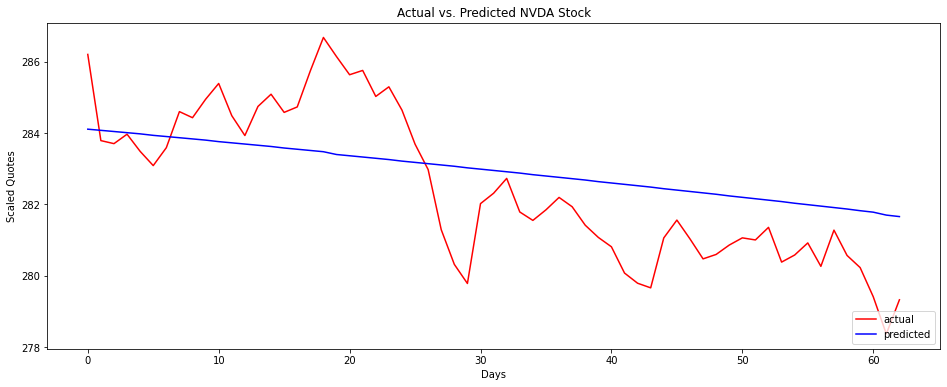

In [68]:
from matplotlib import pyplot as plt
# Combine the predicted and ytest arrays into a single unified array
combined_array = np.concatenate((y_test, predict), axis = 1)
# plot a side by side comparison of Actual versus Predicted stock to compare trends
plt.figure(figsize=(16,6))
plt.plot(combined_array[:,0],color='red', label='actual')
plt.plot(combined_array[:,1],color='blue', label='predicted')
plt.legend(loc = 'lower right')
plt.title('Actual vs. Predicted ' + "NVDA" + ' Stock')
plt.xlabel('Days')
plt.ylabel('Scaled Quotes')
plt.show()

In [79]:
nvda.head(10)

[Row(stock='NVDA', date='2018-11-02', volume=11320900, open=217.72999572753906, close=214.9199981689453, high=222.0, low=210.2100067138672, adjusted_close=214.9199981689453),
 Row(stock='NVDA', date='2018-11-01', volume=14163200, open=212.3000030517578, close=218.11000061035156, high=218.49000549316406, low=207.19000244140625, adjusted_close=218.11000061035156),
 Row(stock='NVDA', date='2018-10-31', volume=18644300, open=209.64999389648438, close=210.8300018310547, high=212.58999633789062, low=204.00999450683594, adjusted_close=210.8300018310547),
 Row(stock='NVDA', date='2018-10-30', volume=20179800, open=186.5500030517578, close=203.0, high=203.39999389648438, low=185.6199951171875, adjusted_close=203.0),
 Row(stock='NVDA', date='2018-10-29', volume=18950400, open=203.99000549316406, close=185.6199951171875, high=204.1300048828125, low=176.00999450683594, adjusted_close=185.6199951171875),
 Row(stock='NVDA', date='2018-10-26', volume=16619600, open=198.30999755859375, close=198.28999

In [80]:
# try to engineer features a bit differently
# predict for the last 60 days, use last 7, 14, 60, 90, 120 day moving averages as predictors

nvda = df.where(df.stock == "NVDA")
nvda = nvda.withColumn("quarter", quarter(col("date")))
nvda = nvda.withColumn("week_of_year", weekofyear(col("date")))
nvda = nvda.withColumn("year", year(col("date")))
nvda = nvda.withColumn("day_of_week", dayofweek(col("date")))

In [81]:
w = (Window.orderBy(col("date")).rowsBetween(-7, -1))
nvda = nvda.withColumn('open_avg_l7', avg('open').over(w)).orderBy('date')
nvda = nvda.withColumn('lagged_open_avg_l7', lag('open_avg_l7', 60).over(Window.orderBy(col("date"))))
nvda = nvda.drop('open_avg_l7')

w = (Window.orderBy(col("date")).rowsBetween(-14, -1))
nvda = nvda.withColumn('open_avg_l14', avg('open').over(w)).orderBy('date')
nvda = nvda.withColumn('lagged_open_avg_l14', lag('open_avg_l14', 60).over(Window.orderBy(col("date"))))
nvda = nvda.drop('open_avg_l14')

w = (Window.orderBy(col("date")).rowsBetween(-60, -1))
nvda = nvda.withColumn('open_avg_l60', avg('open').over(w)).orderBy('date')
nvda = nvda.withColumn('lagged_open_avg_l60', lag('open_avg_l60', 60).over(Window.orderBy(col("date"))))
nvda = nvda.drop('open_avg_l60')

w = (Window.orderBy(col("date")).rowsBetween(-90, -1))
nvda = nvda.withColumn('open_avg_l90', avg('open').over(w)).orderBy('date')
nvda = nvda.withColumn('lagged_open_avg_l90', lag('open_avg_l90', 60).over(Window.orderBy(col("date"))))
nvda = nvda.drop('open_avg_l90')

w = (Window.orderBy(col("date")).rowsBetween(-120, -1))
nvda = nvda.withColumn('open_avg_l120', avg('open').over(w)).orderBy('date')
nvda = nvda.withColumn('lagged_open_avg_l120', lag('open_avg_l120', 60).over(Window.orderBy(col("date"))))
nvda = nvda.drop('open_avg_l120')

In [82]:
nvda.columns

['stock',
 'date',
 'volume',
 'open',
 'close',
 'high',
 'low',
 'adjusted_close',
 'quarter',
 'week_of_year',
 'year',
 'day_of_week',
 'lagged_open_avg_l7',
 'lagged_open_avg_l14',
 'lagged_open_avg_l60',
 'lagged_open_avg_l90',
 'lagged_open_avg_l120']

In [83]:
w = (Window.orderBy(col("date")).rowsBetween(-7, -1))
nvda = nvda.withColumn('close_avg_l7', avg('close').over(w)).orderBy('date')
nvda = nvda.withColumn('lagged_close_avg_l7', lag('close_avg_l7', 60).over(Window.orderBy(col("date"))))
nvda = nvda.drop('close_avg_l7')

w = (Window.orderBy(col("date")).rowsBetween(-14, -1))
nvda = nvda.withColumn('close_avg_l14', avg('close').over(w)).orderBy('date')
nvda = nvda.withColumn('lagged_close_avg_l14', lag('close_avg_l14', 60).over(Window.orderBy(col("date"))))
nvda = nvda.drop('close_avg_l14')

w = (Window.orderBy(col("date")).rowsBetween(-60, -1))
nvda = nvda.withColumn('close_avg_l60', avg('close').over(w)).orderBy('date')
nvda = nvda.withColumn('lagged_close_avg_l60', lag('close_avg_l60', 60).over(Window.orderBy(col("date"))))
nvda = nvda.drop('close_avg_l60')

w = (Window.orderBy(col("date")).rowsBetween(-90, -1))
nvda = nvda.withColumn('close_avg_l90', avg('close').over(w)).orderBy('date')
nvda = nvda.withColumn('lagged_close_avg_l90', lag('close_avg_l90', 60).over(Window.orderBy(col("date"))))
nvda = nvda.drop('close_avg_l90')

w = (Window.orderBy(col("date")).rowsBetween(-120, -1))
nvda = nvda.withColumn('close_avg_l120', avg('close').over(w)).orderBy('date')
nvda = nvda.withColumn('lagged_close_avg_l120', lag('close_avg_l120', 60).over(Window.orderBy(col("date"))))
nvda = nvda.drop('close_avg_l120')

In [84]:
w = (Window.orderBy(col("date")).rowsBetween(-7, -1))
nvda = nvda.withColumn('high_avg_l7', avg('high').over(w)).orderBy('date')
nvda = nvda.withColumn('lagged_high_avg_l7', lag('high_avg_l7', 60).over(Window.orderBy(col("date"))))
nvda = nvda.drop('high_avg_l7')

w = (Window.orderBy(col("date")).rowsBetween(-14, -1))
nvda = nvda.withColumn('high_avg_l14', avg('high').over(w)).orderBy('date')
nvda = nvda.withColumn('lagged_high_avg_l14', lag('high_avg_l14', 60).over(Window.orderBy(col("date"))))
nvda = nvda.drop('high_avg_l14')

w = (Window.orderBy(col("date")).rowsBetween(-60, -1))
nvda = nvda.withColumn('high_avg_l60', avg('high').over(w)).orderBy('date')
nvda = nvda.withColumn('lagged_high_avg_l60', lag('high_avg_l60', 60).over(Window.orderBy(col("date"))))
nvda = nvda.drop('high_avg_l60')

w = (Window.orderBy(col("date")).rowsBetween(-90, -1))
nvda = nvda.withColumn('high_avg_l90', avg('high').over(w)).orderBy('date')
nvda = nvda.withColumn('lagged_high_avg_l90', lag('high_avg_l90', 60).over(Window.orderBy(col("date"))))
nvda = nvda.drop('high_avg_l90')

w = (Window.orderBy(col("date")).rowsBetween(-120, -1))
nvda = nvda.withColumn('high_avg_l120', avg('high').over(w)).orderBy('date')
nvda = nvda.withColumn('lagged_high_avg_l120', lag('high_avg_l120', 60).over(Window.orderBy(col("date"))))
nvda = nvda.drop('high_avg_l120')

In [85]:
w = (Window.orderBy(col("date")).rowsBetween(-7, -1))
nvda = nvda.withColumn('low_avg_l7', avg('low').over(w)).orderBy('date')
nvda = nvda.withColumn('lagged_low_avg_l7', lag('low_avg_l7', 60).over(Window.orderBy(col("date"))))
nvda = nvda.drop('low_avg_l7')

w = (Window.orderBy(col("date")).rowsBetween(-14, -1))
nvda = nvda.withColumn('low_avg_l14', avg('low').over(w)).orderBy('date')
nvda = nvda.withColumn('lagged_low_avg_l14', lag('low_avg_l14', 60).over(Window.orderBy(col("date"))))
nvda = nvda.drop('low_avg_l14')

w = (Window.orderBy(col("date")).rowsBetween(-60, -1))
nvda = nvda.withColumn('low_avg_l60', avg('low').over(w)).orderBy('date')
nvda = nvda.withColumn('lagged_low_avg_l60', lag('low_avg_l60', 60).over(Window.orderBy(col("date"))))
nvda = nvda.drop('low_avg_l60')

w = (Window.orderBy(col("date")).rowsBetween(-90, -1))
nvda = nvda.withColumn('low_avg_l90', avg('low').over(w)).orderBy('date')
nvda = nvda.withColumn('lagged_low_avg_l90', lag('low_avg_l90', 60).over(Window.orderBy(col("date"))))
nvda = nvda.drop('low_avg_l90')

w = (Window.orderBy(col("date")).rowsBetween(-120, -1))
nvda = nvda.withColumn('low_avg_l120', avg('low').over(w)).orderBy('date')
nvda = nvda.withColumn('lagged_low_avg_l120', lag('low_avg_l120', 60).over(Window.orderBy(col("date"))))
nvda = nvda.drop('low_avg_l120')

In [86]:
w = (Window.orderBy(col("date")).rowsBetween(-7, -1))
nvda = nvda.withColumn('adjusted_close_avg_l7', avg('adjusted_close').over(w)).orderBy('date')
nvda = nvda.withColumn('lagged_adjusted_close_avg_l7', lag('adjusted_close_avg_l7', 60).over(Window.orderBy(col("date"))))
nvda = nvda.drop('adjusted_close_avg_l7')

w = (Window.orderBy(col("date")).rowsBetween(-14, -1))
nvda = nvda.withColumn('adjusted_close_avg_l14', avg('adjusted_close').over(w)).orderBy('date')
nvda = nvda.withColumn('lagged_adjusted_close_avg_l14', lag('adjusted_close_avg_l14', 60).over(Window.orderBy(col("date"))))
nvda = nvda.drop('adjusted_close_avg_l14')

w = (Window.orderBy(col("date")).rowsBetween(-60, -1))
nvda = nvda.withColumn('adjusted_close_avg_l60', avg('adjusted_close').over(w)).orderBy('date')
nvda = nvda.withColumn('lagged_adjusted_close_avg_l60', lag('adjusted_close_avg_l60', 60).over(Window.orderBy(col("date"))))
nvda = nvda.drop('adjusted_close_avg_l60')

w = (Window.orderBy(col("date")).rowsBetween(-90, -1))
nvda = nvda.withColumn('adjusted_close_avg_l90', avg('adjusted_close').over(w)).orderBy('date')
nvda = nvda.withColumn('lagged_adjusted_close_avg_l90', lag('adjusted_close_avg_l90', 60).over(Window.orderBy(col("date"))))
nvda = nvda.drop('adjusted_close_avg_l90')

w = (Window.orderBy(col("date")).rowsBetween(-120, -1))
nvda = nvda.withColumn('adjusted_close_avg_l120', avg('adjusted_close').over(w)).orderBy('date')
nvda = nvda.withColumn('lagged_adjusted_close_avg_l120', lag('adjusted_close_avg_l120', 60).over(Window.orderBy(col("date"))))
nvda = nvda.drop('adjusted_close_avg_l120')

In [87]:
from datetime import datetime, timedelta

last_day = nvda.orderBy('date', ascending=False).select('date').first()[0]
threshold = datetime.strptime(last_day, '%Y-%m-%d').date() - timedelta(days=60)
nvda = nvda.withColumn("is_test", when(col("date") >= threshold, 1).otherwise(0))

In [88]:
nvda.count()

4980

In [89]:
# drop rows with nulls (i.e. first four quarters)
nvda = nvda.na.drop()

In [90]:
nvda.count()

4919

In [91]:
nvda = nvda.toPandas()
nvda.columns

Index(['stock', 'date', 'volume', 'open', 'close', 'high', 'low',
       'adjusted_close', 'quarter', 'week_of_year', 'year', 'day_of_week',
       'lagged_open_avg_l7', 'lagged_open_avg_l14', 'lagged_open_avg_l60',
       'lagged_open_avg_l90', 'lagged_open_avg_l120', 'lagged_close_avg_l7',
       'lagged_close_avg_l14', 'lagged_close_avg_l60', 'lagged_close_avg_l90',
       'lagged_close_avg_l120', 'lagged_high_avg_l7', 'lagged_high_avg_l14',
       'lagged_high_avg_l60', 'lagged_high_avg_l90', 'lagged_high_avg_l120',
       'lagged_low_avg_l7', 'lagged_low_avg_l14', 'lagged_low_avg_l60',
       'lagged_low_avg_l90', 'lagged_low_avg_l120',
       'lagged_adjusted_close_avg_l7', 'lagged_adjusted_close_avg_l14',
       'lagged_adjusted_close_avg_l60', 'lagged_adjusted_close_avg_l90',
       'lagged_adjusted_close_avg_l120', 'is_test'],
      dtype='object')

In [92]:
predictor_features = ['quarter', 'week_of_year', 'year', 'day_of_week',
                       'lagged_open_avg_l7', 'lagged_open_avg_l14', 'lagged_open_avg_l60',
                       'lagged_open_avg_l90', 'lagged_open_avg_l120', 'lagged_high_avg_l7',
                       'lagged_high_avg_l14', 'lagged_high_avg_l60', 'lagged_high_avg_l90',
                       'lagged_high_avg_l120', 'lagged_low_avg_l7', 'lagged_low_avg_l14',
                       'lagged_low_avg_l60', 'lagged_low_avg_l90', 'lagged_low_avg_l120',
                       'lagged_close_avg_l7', 'lagged_close_avg_l14', 'lagged_close_avg_l60',
                       'lagged_close_avg_l90', 'lagged_close_avg_l120',
                       'lagged_adjusted_close_avg_l7', 'lagged_adjusted_close_avg_l14',
                       'lagged_adjusted_close_avg_l60', 'lagged_adjusted_close_avg_l90',
                       'lagged_adjusted_close_avg_l120']
len(predictor_features)

29

In [93]:
from sklearn.preprocessing import MinMaxScaler

# scale the arrays to keep the values between 0 and 1 to match outcomes found in sigmoid or step functions that are used for activation.
minMaxScale = MinMaxScaler()
all_features = predictor_features.copy()
all_features.append('adjusted_close')

minMaxScale.fit(nvda[nvda.is_test == 0][all_features])
testingset = minMaxScale.transform(nvda[nvda.is_test == 1][all_features])
trainingset = minMaxScale.transform(nvda[nvda.is_test == 0][all_features])

In [94]:
# x_train, x_test = nvda[nvda.is_test == 0][predictor_features], nvda[nvda.is_test == 1][predictor_features]
# y_train, y_test = nvda[nvda.is_test == 0]['adjusted_close'], nvda[nvda.is_test == 1]['adjusted_close']
x_train, x_test = trainingset[:, 0:-1], testingset[:, 0:-1]
y_train, y_test = trainingset[:, -1:], testingset[:, -1:]
len(predictor_features)

29

In [95]:
import numpy as np
from keras import models, layers

# Build a Sequential model
model = models.Sequential()
model.add(layers.LSTM(1, input_shape=(1,len(predictor_features)), return_sequences=True))
model.add(layers.LSTM(1, input_shape=(1,len(predictor_features))))
model.add(layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [96]:
# Transform the testing and training data sets into three-dimensional arrays,  batch size, a number of time steps, and a number of features
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))

print('The shape of xtrain is {}: '.format(x_train.shape))
print('The shape of xtest is {}: '.format(x_test.shape))

The shape of xtrain is (4875, 1, 29): 
The shape of xtest is (44, 1, 29): 


In [97]:
# train the model
loss = model.fit(x_train, y_train, batch_size=10, epochs=100)

Epoch 1/100
488/488 [==============================] - 12s 8ms/step - loss: 0.0136
Epoch 2/100
488/488 [==============================] - 4s 8ms/step - loss: 0.0028
Epoch 3/100
488/488 [==============================] - 4s 8ms/step - loss: 0.0011
Epoch 4/100
488/488 [==============================] - 4s 8ms/step - loss: 7.8501e-04
Epoch 5/100
488/488 [==============================] - 4s 8ms/step - loss: 7.1536e-04
Epoch 6/100
488/488 [==============================] - 4s 7ms/step - loss: 6.6093e-04
Epoch 7/100
488/488 [==============================] - 4s 8ms/step - loss: 6.3753e-04
Epoch 8/100
488/488 [==============================] - 4s 8ms/step - loss: 6.0282e-04
Epoch 9/100
488/488 [==============================] - 4s 8ms/step - loss: 6.0079e-04
Epoch 10/100
488/488 [==============================] - 4s 7ms/step - loss: 5.7072e-04
Epoch 11/100
488/488 [==============================] - 3s 6ms/step - loss: 5.6222e-04
Epoch 12/100
488/488 [==============================] - 3s 6ms/

In [98]:
# testing the model
predict = model.predict(x_test)
predict

array([[0.92398834],
       [0.924106  ],
       [0.92419344],
       [0.92425764],
       [0.9254738 ],
       [0.92573255],
       [0.9260665 ],
       [0.92633754],
       [0.92672384],
       [0.92799103],
       [0.92840123],
       [0.9290808 ],
       [0.930076  ],
       [0.93088764],
       [0.9326061 ],
       [0.9332924 ],
       [0.9339502 ],
       [0.93456376],
       [0.9350663 ],
       [0.93657255],
       [0.9367794 ],
       [0.9368866 ],
       [0.936938  ],
       [0.9370563 ],
       [0.93804514],
       [0.9379344 ],
       [0.93772185],
       [0.93748415],
       [0.9372381 ],
       [0.9378951 ],
       [0.9375943 ],
       [0.93733394],
       [0.93702316],
       [0.93672526],
       [0.9375192 ],
       [0.93752915],
       [0.9376354 ],
       [0.9377099 ],
       [0.93779385],
       [0.9387301 ],
       [0.9387227 ],
       [0.9388032 ],
       [0.9387673 ],
       [0.9385327 ]], dtype=float32)

In [99]:
# convert testing values and prediction values back to original form, before calculating the RMSE
ytest_to_inverse = nvda[nvda.is_test == 1]['adjusted_close']
np.array(ytest_to_inverse)
ytest_to_inverse=ytest_to_inverse[:,np.newaxis]
minMaxScale.fit_transform(ytest_to_inverse)
predict = minMaxScale.inverse_transform(predict)
y_test = minMaxScale.inverse_transform(y_test)
nvda[nvda.is_test == 1]["adjusted_close"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


4875    283.700012
4876    278.420013
4877    272.720001
4878    271.859985
4879    274.730011
4880    272.799988
4881    268.200012
4882    271.339996
4883    276.429993
4884    273.929993
4885    271.019989
4886    271.980011
4887    266.279999
4888    263.450012
4889    265.700012
4890    268.410004
4891    266.920013
4892    267.399994
4893    281.019989
4894    289.359985
4895    286.480011
4896    286.730011
4897    279.290009
4898    269.859985
4899    265.769989
4900    265.540009
4901    245.690002
4902    235.130005
4903    246.539993
4904    235.380005
4905    245.830002
4906    243.059998
4907    239.529999
4908    229.169998
4909    231.220001
4910    221.059998
4911    199.410004
4912    207.839996
4913    198.289993
4914    185.619995
4915    203.000000
4916    210.830002
4917    218.110001
4918    214.919998
Name: adjusted_close, dtype: float32

In [100]:
print(metrics.mean_absolute_error(y_test, predict))
print(metrics.mean_squared_error(y_test, predict))
print(np.sqrt(metrics.mean_squared_error(y_test, predict)))
# print(metrics.r2_score(y_test, predict))

8.800483591626222
127.99313912772419
11.313405284339645


In [350]:
[(y_test.tolist()[i], predict[i]) for i in range(len(y_test))]

[([290.4816426733066], array([280.17618], dtype=float32)),
 ([288.520608574551], array([280.19687], dtype=float32)),
 ([286.4035781037977], array([280.21527], dtype=float32)),
 ([286.08416127903087], array([280.2542], dtype=float32)),
 ([287.1501119296535], array([280.36487], dtype=float32)),
 ([286.43328576135826], array([280.461], dtype=float32)),
 ([284.72481775700237], array([280.54813], dtype=float32)),
 ([285.89103316870114], array([280.6354], dtype=float32)),
 ([287.7814988294667], array([280.7179], dtype=float32)),
 ([286.8529786816757], array([280.81064], dtype=float32)),
 ([285.77217986951007], array([280.89563], dtype=float32)),
 ([286.1287397670834], array([281.00998], dtype=float32)),
 ([284.0117092963301], array([281.18445], dtype=float32)),
 ([282.9606294761995], array([281.33725], dtype=float32)),
 ([283.79629760921136], array([281.51], dtype=float32)),
 ([284.802810275764], array([281.64792], dtype=float32)),
 ([284.24941589471234], array([281.78003], dtype=float32)),


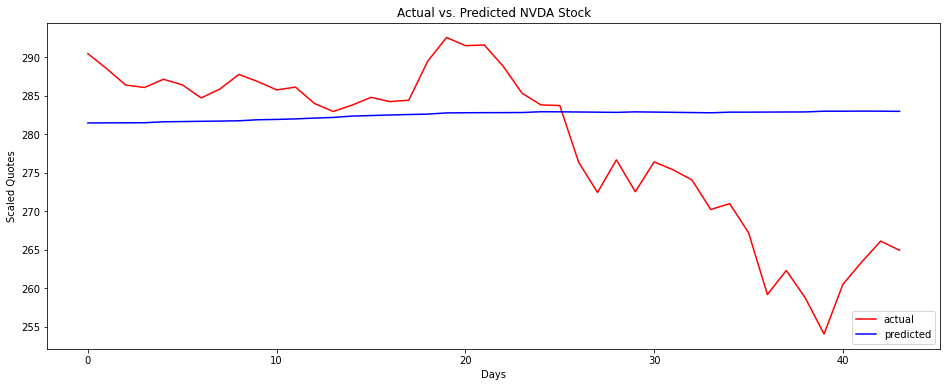

In [101]:
from matplotlib import pyplot as plt
# Combine the predicted and ytest arrays into a single unified array
combined_array = np.concatenate((y_test, predict), axis = 1)
# plot a side by side comparison of Actual versus Predicted stock to compare trends
plt.figure(figsize=(16,6))
plt.plot(combined_array[:,0],color='red', label='actual')
plt.plot(combined_array[:,1],color='blue', label='predicted')
plt.legend(loc = 'lower right')
plt.title('Actual vs. Predicted ' + "NVDA" + ' Stock')
plt.xlabel('Days')
plt.ylabel('Scaled Quotes')
plt.show()

In [ ]:
# look at feature importance after all the features are engineered